
# Traffic Prediction → Anomaly Detection (Hands‑On Tutorial)

**Goal:** Build a supervised regression model to predict traffic, evaluate models, and use prediction residuals to flag anomalies. You’ll complete key steps yourself in the **Your Turn** cells.

**Dataset:** [Kaggle – Traffic Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset)

> Tip: In this notebook, some cells are pre-filled (e.g., Decision Tree, Linear Regression) and others are left **empty** for you to implement.

---
## Learning Outcomes
By the end, you will be able to:
1. Load and explore a tabular time-based traffic dataset.
2. Split data properly (including time-aware splits).
3. Preprocess features (impute, scale, encode) without leakage using `Pipeline`/`ColumnTransformer`.
4. Engineer time features (hour, day-of-week) and simple lags/rolling stats.
5. Train baseline models (Decision Tree, Linear Regression) and add your own.
6. Evaluate with **MAE** (provided) and add at least one more metric yourself.
7. Use residuals to detect anomalies and observe how **thresholds** change counts.

---



## 0) Setup & Imports
- If you run on Kaggle/Colab, you may need to install extra packages.
- Place the dataset CSV locally or adjust the path.

> **Do not** hard-code preprocessing on the whole dataset before the split. Use pipelines to avoid data leakage.


In [ ]:

# (Optional) Install extra libraries if needed
# !pip install --quiet seaborn scikit-learn matplotlib pandas numpy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
plt.style.use('seaborn-v0_8')
sns.set_context('talk')



## 1) Data Loading
**Task:** Load the Kaggle dataset into a DataFrame and ensure the timestamp column is parsed as `datetime`.

> You may need to download the CSV from Kaggle manually (or use the Kaggle API) and set `DATA_PATH` below. Inspect `df.columns` to identify the **target** and the **timestamp** column names.


In [ ]:

# EDIT HERE: Set your dataset path and file name
DATA_PATH = '.'  # e.g., './data'
FILE_NAME = 'traffic.csv'  # <-- update to the actual file, e.g., 'Metro_Interstate_Traffic_Volume.csv'

# Try to read the CSV (adjust encoding or separator if needed)
file_path = os.path.join(DATA_PATH, FILE_NAME)
assert os.path.exists(file_path), f"File not found: {file_path}. Please place the dataset and update FILE_NAME."

df = pd.read_csv(file_path)
print('Shape:', df.shape)
print('Columns:', list(df.columns))

df.head()


Shape: (48120, 4)
Columns: ['DateTime', 'Junction', 'Vehicles', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We identify the timestamp column and the target column based on df.head()
# For this dataset:
# - The timestamp column is "DateTime"
# - The target we want to predict is "TrafficVolume"

TIMESTAMP_COL = "DateTime"
TARGET_COL = "Vehicles"

# Parse datetime if available
if TIMESTAMP_COL is not None and TIMESTAMP_COL in df.columns:
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors='coerce')

    # Drop rows where timestamp could not be parsed
    before = len(df)
    df = df.dropna(subset=[TIMESTAMP_COL]).copy()
    after = len(df)

    print(f"Dropped {before - after} rows due to unparsable timestamps.")
else:
    print("(Info) TIMESTAMP_COL not set or not found. Proceeding without explicit time parsing.")

# Simple safety check for target column
assert TARGET_COL in df.columns, "Please set TARGET_COL to a valid column name."

print("Timestamp column:", TIMESTAMP_COL)
print("Target column:", TARGET_COL)

Dropped 0 rows due to unparsable timestamps.
Timestamp column: DateTime
Target column: Vehicles



## 2) Exploratory Data Analysis (EDA)
**Task:** Understand the data’s structure, missingness, distributions, and time patterns.

Suggested steps:
- `df.info()`, `df.describe()`
- Missing value counts
- Distribution plots for target
- If time column exists: line plot over time, seasonal patterns (hour/day-of-week)


In [ ]:

# Basic structure
print(df.info())
df.describe(include='all').T.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
None


,count,mean,min,25%,50%,75%,max,std
DateTime,48120,2016-09-19 06:03:56.109725696,2015-11-01 00:00:00,2016-04-16 01:45:00,2016-09-30 03:30:00,2017-02-25 16:00:00,2017-06-30 23:00:00,NaN
Junction,48120.0,2.180549,1.0,1.0,2.0,3.0,4.0,0.966955
Vehicles,48120.0,22.791334,1.0,9.0,15.0,29.0,180.0,20.750063
ID,48120.0,20163302501.220448,20151101001.0,20160416019.0,20160930037.0,20170225162.25,20170630234.0,5944853.800152


In [ ]:

# Missing values overview
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]


,0


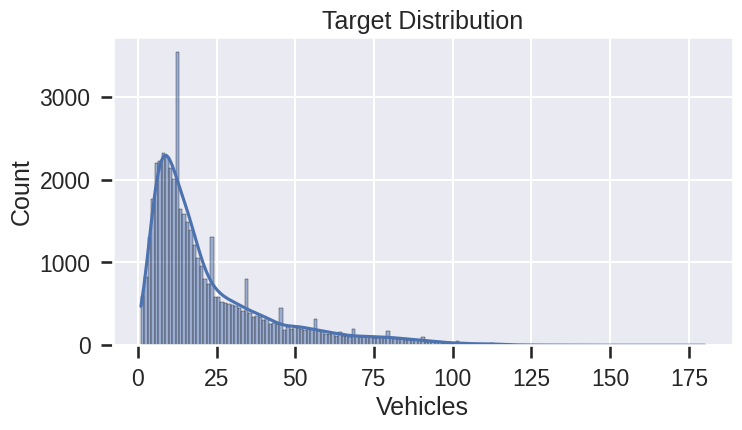

In [ ]:

# Target distribution
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(df[TARGET_COL].dropna(), kde=True, ax=ax)
ax.set_title('Target Distribution')
ax.set_xlabel(TARGET_COL)
plt.show()


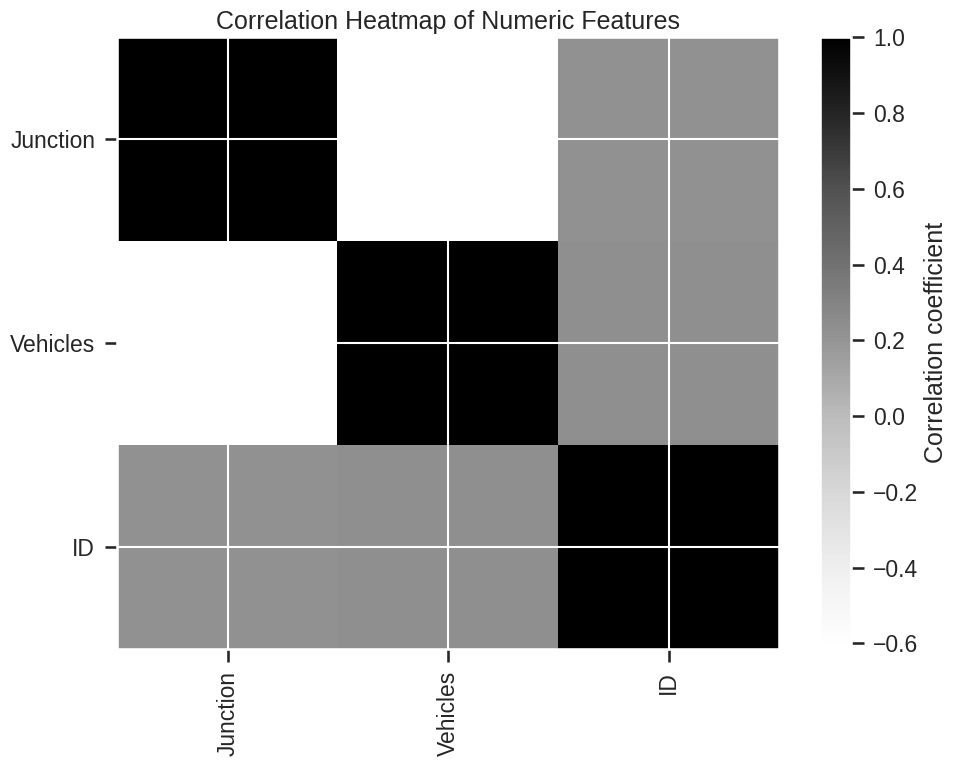

In [ ]:

# Your Turn: Add at least one more EDA plot (e.g., boxplot by categorical feature, correlation heatmap, etc.)
# Start here:
# Select numeric columns only
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect='auto')
plt.colorbar(label='Correlation coefficient')

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

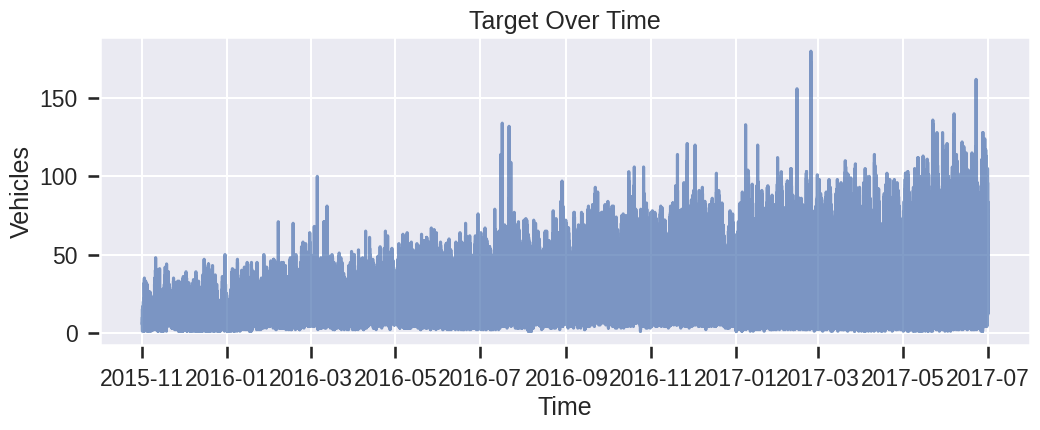

In [ ]:

# Optional: Time-series look (if timestamp available)
if TIMESTAMP_COL is not None and TIMESTAMP_COL in df.columns:
    df_sorted = df.sort_values(TIMESTAMP_COL)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(df_sorted[TIMESTAMP_COL], df_sorted[TARGET_COL], alpha=0.7)
    ax.set_title('Target Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel(TARGET_COL)
    plt.show()
else:
    print("(Info) Skipping time plot – no TIMESTAMP_COL set.")



## 3) Train–Test Split
**Task:** Create training and test sets. If a timestamp is available, use a **time-aware split** (earlier data → train, later data → test). Otherwise, use a standard random split.


In [ ]:

# Define features and target
feature_cols = [c for c in df.columns if c != TARGET_COL]
X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

# Identify column types
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
# (We will handle datetime-derived features separately during feature engineering.)

if TIMESTAMP_COL is not None and TIMESTAMP_COL in df.columns:
    # Time-aware split: sort by time and split by a cut point (e.g., last 20% as test)
    df_sorted = df.sort_values(TIMESTAMP_COL)
    split_idx = int(0.8 * len(df_sorted))
    train_df = df_sorted.iloc[:split_idx].copy()
    test_df  = df_sorted.iloc[split_idx:].copy()

    X_train = train_df[feature_cols]
    y_train = train_df[TARGET_COL]
    X_test  = test_df[feature_cols]
    y_test  = test_df[TARGET_COL]
else:
    # Random split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )

print('Train size:', len(X_train), ' Test size:', len(X_test))
print('Numeric:', len(numeric_cols), 'Categorical:', len(categorical_cols))


Train size: 38496  Test size: 9624
Numeric: 2 Categorical: 0



## 4) Data Preprocessing (No Leakage)
We will:
- **Impute** missing values (median for numeric, most frequent for categorical)
- **Scale** numeric features
- **Encode** categorical features (one‑hot)

These are applied **inside a Pipeline** and **fitted only on training data**.


In [ ]:

# Column-wise transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ], remainder='drop'
)



## 5) Feature Engineering
**Goal:** Create informative features to improve prediction.

Common ideas for traffic:
- **Time**: hour, day-of-week, is_weekend, month
- **Lags**: previous target values (e.g., `lag_1`, `lag_24`)
- **Rolling stats**: rolling mean/std over recent window

> We’ll implement **time features** here. You’ll add **lags/rolling** yourself.


In [ ]:

# Add time-based features if timestamp exists
if TIMESTAMP_COL is not None and TIMESTAMP_COL in df.columns:
    def add_time_features(frame):
        f = frame.copy()
        ts = pd.to_datetime(f[TIMESTAMP_COL], errors='coerce')
        f['hour'] = ts.dt.hour
        f['dayofweek'] = ts.dt.dayofweek
        f['month'] = ts.dt.month
        f['is_weekend'] = ts.dt.dayofweek >= 5
        return f

    # Apply to train/test consistently (avoid leakage by deriving only from given rows)
    X_train_fe = add_time_features(X_train)
    X_test_fe  = add_time_features(X_test)

    # Update categorical/numeric lists if needed
    numeric_cols = list(set(numeric_cols + ['hour','dayofweek','month']))
    if 'is_weekend' not in categorical_cols and 'is_weekend' in X_train_fe.columns:
        categorical_cols = categorical_cols + ['is_weekend']
else:
    X_train_fe, X_test_fe = X_train.copy(), X_test.copy()

print('Feature-engineered shapes:', X_train_fe.shape, X_test_fe.shape)


Feature-engineered shapes: (38496, 7) (9624, 7)


In [ ]:
# We add ONE lag feature and ONE rolling mean feature.
# Important: we do this separately for train and test to avoid leakage.

# Make copies so we don't modify original data
X_train_fe = X_train_fe.copy()
X_test_fe = X_test_fe.copy()

# ---------------------------
# 1) Add LAG feature (lag_1)
# ---------------------------
# Shift the target by 1 step within each split
X_train_fe['lag_1'] = y_train.shift(1)
X_test_fe['lag_1'] = y_test.shift(1)

# ---------------------------
# 2) Add ROLLING MEAN feature (rolling_3)
# ---------------------------
# Rolling mean of past 3 target values
X_train_fe['rolling_3'] = y_train.shift(1).rolling(window=3).mean()
X_test_fe['rolling_3'] = y_test.shift(1).rolling(window=3).mean()

# ---------------------------
# 3) Handle missing values created by lag/rolling
# ---------------------------
# We drop the first few rows that have NaN due to lag/rolling
X_train_fe = X_train_fe.dropna()
y_train = y_train.loc[X_train_fe.index]

X_test_fe = X_test_fe.dropna()
y_test = y_test.loc[X_test_fe.index]

print("Lag & rolling features added!")
print("New shapes:", X_train_fe.shape, X_test_fe.shape)

Lag & rolling features added!
New shapes: (38493, 9) (9621, 9)



## 6) Model Selection & Training
We’ll demonstrate two baseline models:
- **Decision Tree Regressor**
- **Linear Regression**

You will add more models later (e.g., RandomForest, SVM, etc.).


In [ ]:

# Decision Tree (Demonstration)
model_tree = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=None))
])
model_tree.fit(X_train_fe, y_train)
y_pred_tree = model_tree.predict(X_test_fe)
tree_mae = mean_absolute_error(y_test, y_pred_tree)
print(f"Decision Tree MAE: {tree_mae:.4f}")


Decision Tree MAE: 11.0446


In [ ]:

# Linear Regression (Demonstration)
model_lin = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
model_lin.fit(X_train_fe, y_train)
y_pred_lin = model_lin.predict(X_test_fe)
lin_mae = mean_absolute_error(y_test, y_pred_lin)
print(f"Linear Regression MAE: {lin_mae:.4f}")


Linear Regression MAE: 11.6256


**bold text**
### Your Turn: Add Additional Models
Suggested options (with library links):

* RandomForestRegressor — <https://scikit-learn.org/stable/modules/
generated/sklearn.ensemble.RandomForestRegressor.html>
* Support Vector Regressor (SVR) — <https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html>
* LGBMRegressor (LightGBM) — <https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html>
* KNeighborsRegressor — <https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html>
* Polynomial Regression (PolynomialFeatures + LinearRegression) — <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html>
* Ensemble Learning methods (overview) — <https://scikit-learn.org/stable/modules/ensemble.html>`

Create a pipeline like above, fit on `X_train_fe, y_train`, predict on `X_test_fe`, compute MAE.


In [ ]:

# Your Turn: Model #1
# Example skeleton:
# from sklearn.ensemble import RandomForestRegressor
# model_rf = Pipeline(steps=[
#     ("preprocess", preprocessor),
#     ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED))
# ])
# model_rf.fit(X_train_fe, y_train)
# y_pred_rf = model_rf.predict(X_test_fe)
# rf_mae = mean_absolute_error(y_test, y_pred_rf)
# print(f"Random Forest MAE: {rf_mae:.4f}")



In [ ]:

# Your Turn: Model #2 Random Forest

# Keep X and y perfectly aligned
X = df.drop(columns=[TARGET_COL, TIMESTAMP_COL])
y = df[TARGET_COL]

# Drop rows where any numeric or categorical feature is missing
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns=[TARGET_COL])
y = Xy[TARGET_COL]

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)




Train X shape: (38496, 2)
Train y shape: (38496,)


In [ ]:
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {rf_mae:.4f}")


Random Forest MAE: 10.7178


In [ ]:

# Your Turn: Model #3 SVR

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# SVR can be slow on large datasets — using a subset is often necessary
# If needed, you can sample 20k rows for training to speed up SVR
X_train_svr = X_train
y_train_svr = y_train

if len(X_train) > 20000:
    print("Subsampling training data for SVR (20k samples)...")
    sample_idx = np.random.choice(len(X_train), 20000, replace=False)
    X_train_svr = X_train.iloc[sample_idx]
    y_train_svr = y_train.iloc[sample_idx]

# SVR pipeline
model_svr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", SVR(kernel='rbf', C=10, epsilon=0.5))  # RBF kernel is common
])

# Fit
model_svr.fit(X_train_svr, y_train_svr)

# Predict
y_pred_svr = model_svr.predict(X_test)

# Evaluate
svr_mae = mean_absolute_error(y_test, y_pred_svr)
print(f"SVR MAE: {svr_mae:.4f}")



Subsampling training data for SVR (20k samples)...
SVR MAE: 21.3285



## 7) Model Evaluation & Comparison
We will collect **MAE** for each model into a comparison table.

> Your task: add **at least one** more metric (e.g., RMSE, R², MAPE) and include it in the table.

* RMSE (Root Mean Squared Error) <https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error>
Computes the square root of MSE — penalizes large errors more strongly.


* R² Score (Coefficient of Determination) <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html>
Measures how well the model explains variance in the data (higher is better).


* MAPE (Mean Absolute Percentage Error) <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html>
Shows prediction error as a percentage, useful for interpretability.


* MSE (Mean Squared Error) <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html>
Square error measure often used before computing RMSE.


In [ ]:

# Collect MAEs; extend this dict with your models and your additional metrics
results = []

results.append({
    'model': 'Decision Tree',
    'mae': float(tree_mae),
    # Add more metrics here (e.g., 'rmse': ..., 'r2': ...)
})

results.append({
    'model': 'Linear Regression',
    'mae': float(lin_mae),
    # Add more metrics here
})

# If you trained extra models, append them similarly
# results.append({'model': 'Random Forest', 'mae': float(rf_mae)})

results_df = pd.DataFrame(results)
results_df.sort_values('mae')


,model,mae
0,Decision Tree,11.044590
1,Linear Regression,11.625601



## 8) Predictions for Anomaly Detection
We’ll pick **one model** (by default Linear Regression) and compute residuals on the **test** set.
Anomalies = points where the absolute error exceeds a chosen threshold.


In [ ]:

# Choose the model to use for anomaly detection
chosen_model_name = 'Linear Regression'  # change to 'Decision Tree' or your best model

if chosen_model_name == 'Linear Regression':
    y_pred = y_pred_lin
elif chosen_model_name == 'Decision Tree':
    y_pred = y_pred_tree
else:
    # Add your own branches if you trained additional models, e.g. 'Random Forest'
    raise ValueError("Please set chosen_model_name to a trained model.")

residuals = y_test.values - y_pred
abs_res = np.abs(residuals)

summary = pd.Series(abs_res).describe(percentiles=[0.5, 0.9, 0.95, 0.99])
summary


,0
count,9621.000000
mean,11.625601
std,14.210550
min,0.010274
50%,6.680355
90%,31.576190
95%,46.562360
99%,64.477882
max,142.421707


### **Understanding Thresholds in Anomaly Detection (Simple Explanation)**

When our model makes predictions, it sometimes makes small mistakes and sometimes big mistakes.  
We call these mistakes **residuals** (actual value − predicted value).

- **Small residual → normal behaviour**  
- **Large residual → something unusual may have happened (anomaly)**

To detect anomalies, we choose a **threshold**.  
If the residual is **above the threshold**, we mark it as an anomaly.

---

### **Why thresholds matter**

- A **lower threshold** → more points will cross it → **more anomalies detected**  
- A **higher threshold** → fewer points cross it → **fewer anomalies detected**

So the threshold controls **how sensitive** the anomaly detector is.

---

### **Data‑Driven Thresholds Used Here**

We use percentiles of the absolute residuals:

- **95th Percentile**  
  Means: the top **5%** biggest errors are flagged as anomalies.  
  → More sensitive, detects *more* anomalies.

- **99th Percentile**  
  Means: the top **1%** biggest errors are flagged as anomalies.  
  → More strict, detects *fewer* anomalies — only very large errors.

These are **data‑driven**, meaning they come from the model’s own error distribution, not from guessing.

---

### **Your Task**

Add **one more threshold of your choice**, for example:

- A **fixed number** (e.g., `threshold = 50`)  
- Another **percentile** (e.g., `90th percentile`)  

Then compare how the number of anomalies changes.

This will help you understand how **changing the threshold changes the sensitivity of anomaly detection**.

In [ ]:

# Provided thresholds (percentile-based)
q95 = np.percentile(abs_res, 95)
q99 = np.percentile(abs_res, 99)

thresholds = [
    (f"P95={q95:.3f}", q95),
    (f"P99={q99:.3f}", q99),
]

# Your Turn: Add at least one more threshold, e.g., a fixed value or another percentile
# Example:
# fixed = 2.0  # replace with something meaningful for your target scale
# thresholds.append((f"Fixed={fixed}", fixed))
# Additional threshold: 90th percentile
q90 = np.percentile(abs_res, 90)
thresholds.append((f"P90={q90:.3f}", q90))

anomaly_tables = []
for label, tau in thresholds:
    is_anom = abs_res > tau
    count = is_anom.sum()
    frac = count / len(abs_res)
    anomaly_tables.append({
        'threshold': label,
        'value': float(tau),
        'anomaly_count': int(count),
        'anomaly_frac': float(frac)
    })

anomalies_df = pd.DataFrame(anomaly_tables).sort_values('value')
anomalies_df


,threshold,value,anomaly_count,anomaly_frac
2,P90=31.576,31.576190,962,0.099990
0,P95=46.562,46.562360,481,0.049995
1,P99=64.478,64.477882,97,0.010082



## 10) Visualize Anomalies
- **Residuals histogram** with thresholds
- **Actual vs Predicted over time** (if timestamp is available), with anomalies highlighted


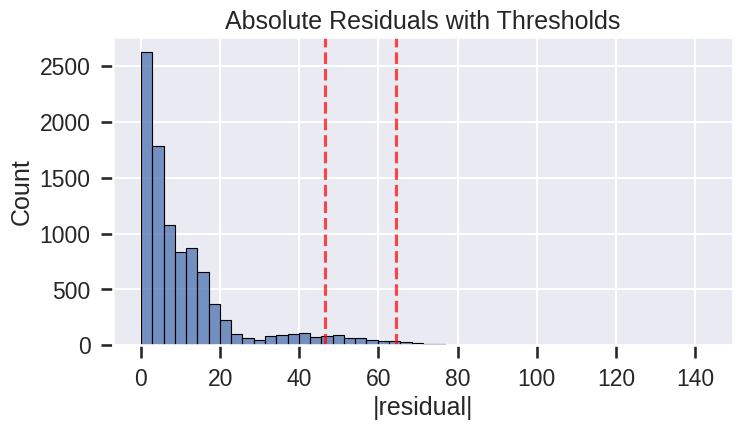

In [ ]:

# Residuals histogram with threshold lines
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(abs_res, bins=50, ax=ax)
for label, tau in thresholds:
    ax.axvline(tau, color='red', linestyle='--', alpha=0.7)
ax.set_title('Absolute Residuals with Thresholds')
ax.set_xlabel('|residual|')
plt.show()


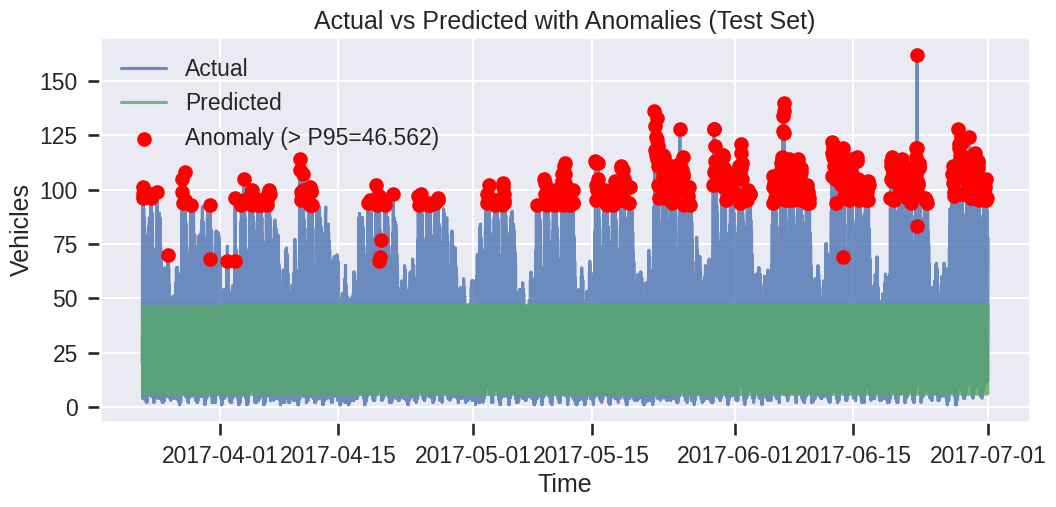

In [ ]:

# Actual vs Predicted over time with anomalies highlighted (if timestamp available)
if TIMESTAMP_COL is not None and TIMESTAMP_COL in df.columns:
    # We need the test timestamps, aligned with y_test order used above
    if TIMESTAMP_COL in X_test_fe.columns:
        ts_test = pd.to_datetime(X_test_fe[TIMESTAMP_COL])
    else:
        # If TIMESTAMP_COL was not retained in features (common), pull from the original test frame
        if 'test_df' in globals():
            ts_test = pd.to_datetime(test_df[TIMESTAMP_COL].iloc[:len(y_test)].values)
        else:
            ts_test = pd.Series(range(len(y_test)))  # fallback

    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(ts_test, y_test.values, label='Actual', alpha=0.8)
    ax.plot(ts_test, y_pred, label='Predicted', alpha=0.8)

    # Mark anomalies for the FIRST threshold in the list
    if len(thresholds) > 0:
        first_tau = thresholds[0][1]
        is_anom = abs_res > first_tau
        ax.scatter(ts_test[is_anom], y_test.values[is_anom], color='red', label=f'Anomaly (> {thresholds[0][0]})', zorder=3)

    ax.set_title('Actual vs Predicted with Anomalies (Test Set)')
    ax.set_xlabel('Time')
    ax.set_ylabel(TARGET_COL)
    ax.legend()
    plt.show()
else:
    print("(Info) Skipping time plot – no TIMESTAMP_COL set.")
